# **Problema de clasificacion binaria: Regresion Logistica**

En este ejercicio vamos a analizar una muestra de datos para clasificacion binaria. Inicialmente partimos del supuesto que nuestros datos se comportan como el siguiente modelo:

$$
\begin{align*}
    Y = f(X) + \varepsilon
\end{align*}
$$

De donde $X \in \mathbb{R}^d$ son las caracteristicas (features) que nos interesa contrarrestar con la salida $Y \in \mathbb{R}$. Ademas tenemos que $\varepsilon \sim \mathcal{N}(0, \sigma^2)$ es el ruido inherente de la muestra aleatoria escogida.

Para un problema de clasificacion binaria, es natural pensar que la variable aleatoria de salida $Y$ tenga solamente dos resultados, por lo cual podemos considerar que tiene una distribucion Bernoulli, es decir, tenemos que $Y \sim \text{Bernoullli}(p)$ por lo cual tiene la siguiente funcion densidad de masa:

$$
\begin{align*}
    g(y) = p^y(1-p)^{n-y}
\end{align*}
$$

Sin embargo, recordemos que nos interesa es poder conocer el comportamiento de la variable aleatoria condicional $Y | X=x$. Para cada valor $x \in \mathcal{X}$ tendremos una correspondiente salida, y a esta salida le correspondera una probabilidad. Dicho esto, es logico pensar que $Y | X=x$ tambien tendra una distribucion Bernoulli, en donde $p$ dependera del $x$ escogido, es decir, tenemos que $Y | X=x \sim \text{Bernoulli}(p_x)$ y la idea es (punto a punto) poder hallar un estimador de esta probabilidad.

----

## **Datos del modelo**

Vamos a empezar importando un dataset de clasificacion binaria. En este caso vamos a hacer algo sencillo y usar las siguientes variables:

$$
\begin{align*}
    X: \text{Radio promedio del tumor (m)} \\
    y: \text{El tumor es maligno o benigno}
\end{align*}
$$

Aca nos podemos dar cuenta que realmente no tenemos un vector de caracteristicas, sino simplemente un escalar. Sin embargo es bueno acostumbrarse a ver esto como un vector ya que computacionalmente es como las librerias de inteligencia artificial suelen hacer los calculos

In [257]:
import pandas as pd

df = pd.read_csv("../data/breast-cancer.csv")

df.sample(n=5)

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
141    869104         M        16.11         18.05          105.10      813.0   
148  86973702         B        14.44         15.18           93.97      640.1   
41     855563         M        10.95         21.35           71.90      371.1   
86   86135501         M        14.48         21.46           94.25      648.2   
107    863270         B        12.36         18.54           79.01      466.7   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
141          0.09721           0.11370         0.09447              0.05943   
148          0.09970           0.10210         0.08487              0.05532   
41           0.12270           0.12180         0.10440              0.05669   
86           0.09444           0.09947         0.12040              0.04938   
107          0.08477           0.06815         0.02643              0.01921   

     ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
141  ...          25.27           129.00      1233.0            0.1314   
148  ...          19.85           108.60       766.9            0.1316   
41   ...          35.34            87.22       514.0            0.1909   
86   ...          29.25           108.40       808.9            0.1306   
107  ...          27.49            85.56       544.1            0.1184   

     compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
141             0.2236           0.2802               0.12160          0.2792   
148             0.2735           0.3103               0.15990          0.2691   
41              0.2698           0.4023               0.14240          0.2964   
86              0.1976           0.3349               0.12250          0.3020   
107             0.1963           0.1937               0.08442          0.2983   

     fractal_dimension_worst  Unnamed: 32  
141                  0.08158          NaN  
148                  0.07683          NaN  
41                   0.09606          NaN  
86                   0.06846          NaN  
107                  0.07185          NaN  

[5 rows x 33 columns]

----

## **Transformaciones del dataset**

Ya que ahora conocemos los datos, podemos identificar las columnas que queremos usar, que en este caso seran `radius_mean` y `diagnosis`. Sin embargo podemos observar que la columna del diagnostico, si bien es binaria, sus datos no son numericos, por lo cual podemos hacer una transformacion para convertirlos

In [258]:
df = df.drop(columns='Unnamed: 32')
df['diagnosis'] = df['diagnosis'].apply(lambda x: 1 if x == "M" else 0)

In [259]:
df.sample(n=5)

id  diagnosis  radius_mean  texture_mean  perimeter_mean  \
490  91376701          0        12.25         22.44           78.18   
445   9110720          0        11.99         24.89           77.61   
109    864018          0        11.34         21.26           72.48   
281   8912055          0        11.74         14.02           74.24   
4    84358402          1        20.29         14.34          135.10   

     area_mean  smoothness_mean  compactness_mean  concavity_mean  \
490      466.5          0.08192           0.05200         0.01714   
445      441.3          0.10300           0.09218         0.05441   
109      396.5          0.08759           0.06575         0.05133   
281      427.3          0.07813           0.04340         0.02245   
4       1297.0          0.10030           0.13280         0.19800   

     concave points_mean  ...  radius_worst  texture_worst  perimeter_worst  \
490              0.01261  ...         14.17          31.99            92.74   
445              0.04274  ...         12.98          30.36            84.48   
109              0.01899  ...         13.01          29.15            83.99   
281              0.02763  ...         13.31          18.26            84.70   
4                0.10430  ...         22.54          16.67           152.20   

     area_worst  smoothness_worst  compactness_worst  concavity_worst  \
490       622.9            0.1256             0.1804          0.12300   
445       513.9            0.1311             0.1822          0.16090   
109       518.1            0.1699             0.2196          0.31200   
281       533.7            0.1036             0.0850          0.06735   
4        1575.0            0.1374             0.2050          0.40000   

     concave points_worst  symmetry_worst  fractal_dimension_worst  
490               0.06335          0.3100                  0.08203  
445               0.12020          0.2599                  0.08251  
109               0.08278          0.2829                  0.08832  
281               0.08290          0.3101                  0.06688  
4                 0.16250          0.2364                  0.07678  

[5 rows x 32 columns]

In [260]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X = df[['radius_mean']]
y = df['diagnosis']

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

print(X[:50].T)
print("\n")
print(y[:50].values)

[[0.52103744 0.64314449 0.60149557 0.2100904  0.62989256 0.25883856
  0.5333428  0.31847224 0.28486914 0.25931185 0.42780065 0.41644186
  0.57688485 0.41975484 0.31941881 0.35775474 0.36438071 0.43300677
  0.60717497 0.31042643 0.2886554  0.11940934 0.3956174  0.6710682
  0.45761749 0.48080837 0.35964788 0.55038099 0.39372427 0.50115954
  0.55132756 0.22996829 0.47512897 0.58161768 0.43300677 0.46187704
  0.34402953 0.28628899 0.37905249 0.30758673 0.3056936  0.18784609
  0.57215202 0.29812107 0.29291495 0.55227413 0.0575039  0.29291495
  0.23990724 0.30806001]]


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 0 1 0 0]


---

## **Graficas de los datos**

Ya que ahora tenemos almacenadas en variables por separado a $X$ y a $y$ podemos graficar los datos para ver como se comportan

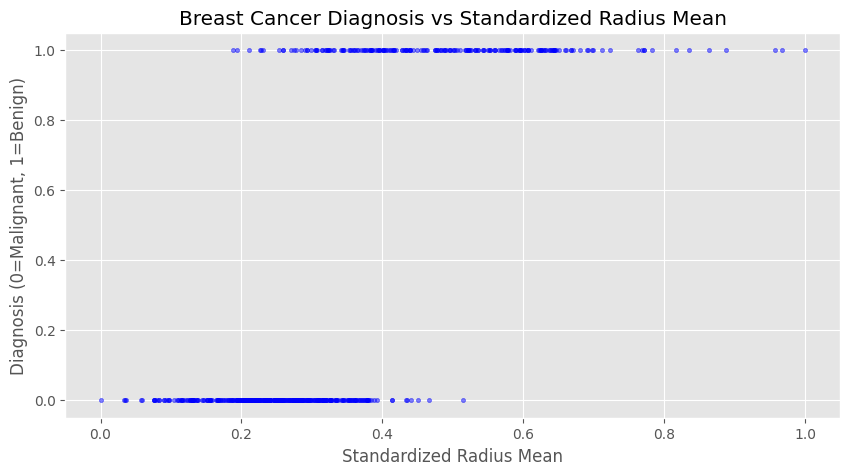

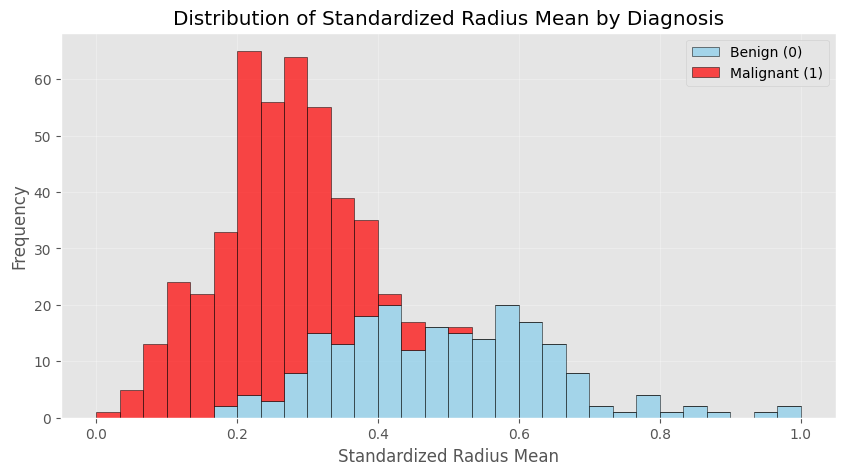

In [261]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("ggplot")

plt.figure(figsize=(10, 5))
plt.scatter(X, y, marker='.', alpha=0.5, c='b')
plt.xlabel('Standardized Radius Mean')
plt.ylabel('Diagnosis (0=Malignant, 1=Benign)')
plt.title('Breast Cancer Diagnosis vs Standardized Radius Mean')
plt.show()

plt.figure(figsize=(10, 5))
# Separate data by target variable
malignant_data = np.array(X[y == 0]).flatten()
benign_data = np.array(X[y == 1]).flatten()

# Create stacked histogram with different colors
plt.hist([benign_data, malignant_data], bins=30, alpha=0.7, 
         color=['skyblue', 'red'], edgecolor='black', 
         label=['Benign (0)', 'Malignant (1)'], stacked=True)
plt.xlabel('Standardized Radius Mean')
plt.ylabel('Frequency')
plt.title('Distribution of Standardized Radius Mean by Diagnosis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---


## **Regresion Logistica**

Recordemos que establecimos que $Y | X=x \sim \text{Bernoulli}(p_x)$, donde queremos estimar $p_x$ para cada valor de $x$. Para ello podriamos proponer cualquier funcion de la forma $p: \mathbb{R} \to [0,1]$ y ademas nos gustaria que fuese diferenciable para temas de optimizacion.

Para ello, definimos la cantidad de *odds* como lo siguiente:

$$
\text{odds}(p) = \frac{p}{1-p}
$$

Esta cantidad es importante pues lo que nos dice basicamente es cuantas veces mas probable es que ocurra el evento versus que no ocurra. Ademas, la particularidad del odds es que es una cantidad que puede tomar cualquier valor positivo.

Sabemos ademas que la probabilidad tiene una naturaleza exponencial, por lo cual es razonable tambien considerar el *log-odds* y de esta forma expresarlo en terminos de una combinacion lineal para de esa manera obtener una expresion cerrada para $p(x)$

$$
\ln\left(\frac{p}{1-p}\right) = \theta_0 + \theta_1x \longrightarrow p(x) = \frac{1}{1 + e^{-(\theta_0 + \theta_1x)}}
$$

----

## **Entrenamiento del modelo**

In [262]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
np.set_printoptions(suppress=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = LogisticRegression()

model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)

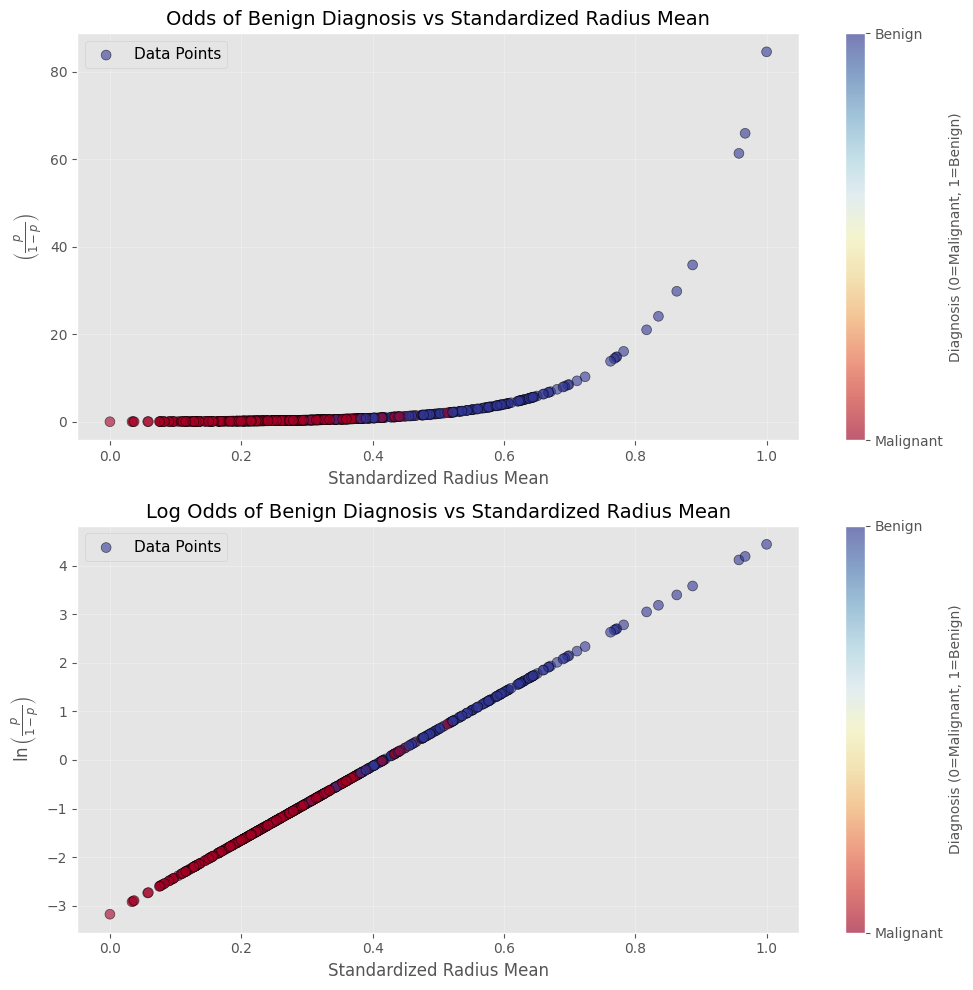

In [263]:
plt.figure(figsize=(10, 10))

# First subplot - Odds
plt.subplot(2, 1, 1)

y_prob_all = model.predict_proba(X)[:, 1]

# Calculate odds for each point
odds_all = y_prob_all / (1 - y_prob_all)

# Create scatter plot
plt.scatter(np.array(X).flatten(), odds_all, alpha=0.6, c=y, cmap='RdYlBu', s=50, 
           edgecolors='black', linewidth=0.5, label='Data Points')

# Create smooth curve for odds
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_prob_range = model.predict_proba(X_range)[:, 1]
odds_range = y_prob_range / (1 - y_prob_range)

plt.xlabel('Standardized Radius Mean', fontsize=12)
plt.ylabel(r'$\left(\frac{p}{1-p}\right)$', fontsize=12)
plt.title('Odds of Benign Diagnosis vs Standardized Radius Mean', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Add colorbar for first subplot
cbar1 = plt.colorbar()
cbar1.set_label('Diagnosis (0=Malignant, 1=Benign)', fontsize=10)
cbar1.set_ticks([0, 1])
cbar1.set_ticklabels(['Malignant', 'Benign'])

# Second subplot - Log Odds
plt.subplot(2, 1, 2)

# Calculate log odds (log of odds)
log_odds_all = np.log(odds_all)

# Create scatter plot for log odds
plt.scatter(np.array(X).flatten(), log_odds_all, alpha=0.6, c=y, cmap='RdYlBu', s=50, 
           edgecolors='black', linewidth=0.5, label='Data Points')

# Create smooth curve for log odds
log_odds_range = np.log(odds_range)
plt.xlabel('Standardized Radius Mean', fontsize=12)
plt.ylabel(r'$\ln\left(\frac{p}{1-p}\right)$', fontsize=12)
plt.title('Log Odds of Benign Diagnosis vs Standardized Radius Mean', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Add colorbar for second subplot
cbar2 = plt.colorbar()
cbar2.set_label('Diagnosis (0=Malignant, 1=Benign)', fontsize=10)
cbar2.set_ticks([0, 1])
cbar2.set_ticklabels(['Malignant', 'Benign'])

plt.tight_layout()
plt.show()

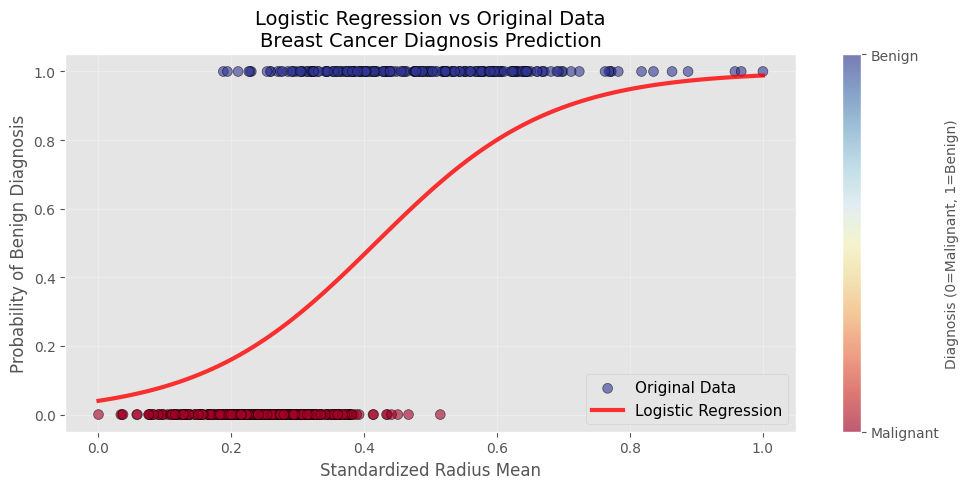

In [264]:
plt.figure(figsize=(10, 5))

# Create a range of X values for smooth logistic curve
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_prob_range = model.predict_proba(X_range)[:, 1]  # Probability of class 1 (benign)

# Plot original scatter data
plt.scatter(X, y, alpha=0.6, c=y, cmap='RdYlBu', s=50, 
           label='Original Data', edgecolors='black', linewidth=0.5)

# Plot logistic regression curve
plt.plot(X_range, y_prob_range, 'red', linewidth=3, 
         label='Logistic Regression', alpha=0.8)

# Customize the plot
plt.xlabel('Standardized Radius Mean', fontsize=12)
plt.ylabel('Probability of Benign Diagnosis', fontsize=12)
plt.title('Logistic Regression vs Original Data\nBreast Cancer Diagnosis Prediction', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Add colorbar for scatter points
cbar = plt.colorbar()
cbar.set_label('Diagnosis (0=Malignant, 1=Benign)', fontsize=10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Malignant', 'Benign'])

plt.tight_layout()
plt.show()

In [265]:
print("Logistic Regression Parameters:")
print(f"Intercept (β₀): {model.intercept_[0]:.6f}")
print(f"Coefficient (β₁): {model.coef_[0][0]:.6f}")


print(f"\nLogistic Regression Equation:")
print(f"log(odds) = {model.intercept_[0]:.6f} + {model.coef_[0][0]:.6f} * X")
print(f"probability = 1 / (1 + exp(-({model.intercept_[0]:.6f} + {model.coef_[0][0]:.6f} * X)))")


Logistic Regression Parameters:
Intercept (β₀): -3.176037
Coefficient (β₁): 7.613992

Logistic Regression Equation:
log(odds) = -3.176037 + 7.613992 * X
probability = 1 / (1 + exp(-(-3.176037 + 7.613992 * X)))


## **Metricas de error**

Lo que hemos hecho hasta el momento ha sido ajustar una regresion logistica a los datos de nuestro modelo, para asi poder estimar las probabilidades de pertenecer a una categoria u otra (predecir si un tumor es maligno o benigno).

Recordemos que cuando realizamos modelos de aprendizaje estadistico, es fundamental el concepto de *metrica* ya que nos permite medir el error de nuestras predicciones. Generalmente usamos como metrica el MSE (Mean Squared Error), que se define matematicamente como:

$$
\begin{align*}
    \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
\end{align*}
$$

donde $y_i$ son los valores reales y $\hat{y}_i$ son las predicciones del modelo para $i = 1, 2, ..., n$ observaciones.

Sin embargo, vamos a observar que en el caso particular de un problema de clasificacion, esta metrica no es muy conveniente por las siguientes razones:

1. **Naturaleza de las predicciones**: En regresion logistica, nuestras predicciones $\hat{y}_i$ son probabilidades en el rango $[0,1]$, mientras que nuestros valores reales $y_i$ son valores discretos (0 ó 1). El MSE penaliza desviaciones cuadráticas, pero no captura adecuadamente la naturaleza probabilistica del problema.

2. **Perdida de informacion**: El MSE trata todas las desviaciones por igual, independientemente de si la prediccion está del lado "correcto" o "incorrecto" del umbral de decisión (típicamente 0.5). Por ejemplo, una prediccion de 0.6 para una clase verdadera 1 tiene el mismo error cuadratico que una predicción de 0.4, pero desde el punto de vista de clasificación, la primera es correcta y la segunda es incorrecta.

3. **Optimizacion**: El MSE no es la función de perdida natural derivada de los principios de máxima verosimilitud para la distribucion Bernoulli, lo que puede llevar a problemas de optimizacion y convergencia.

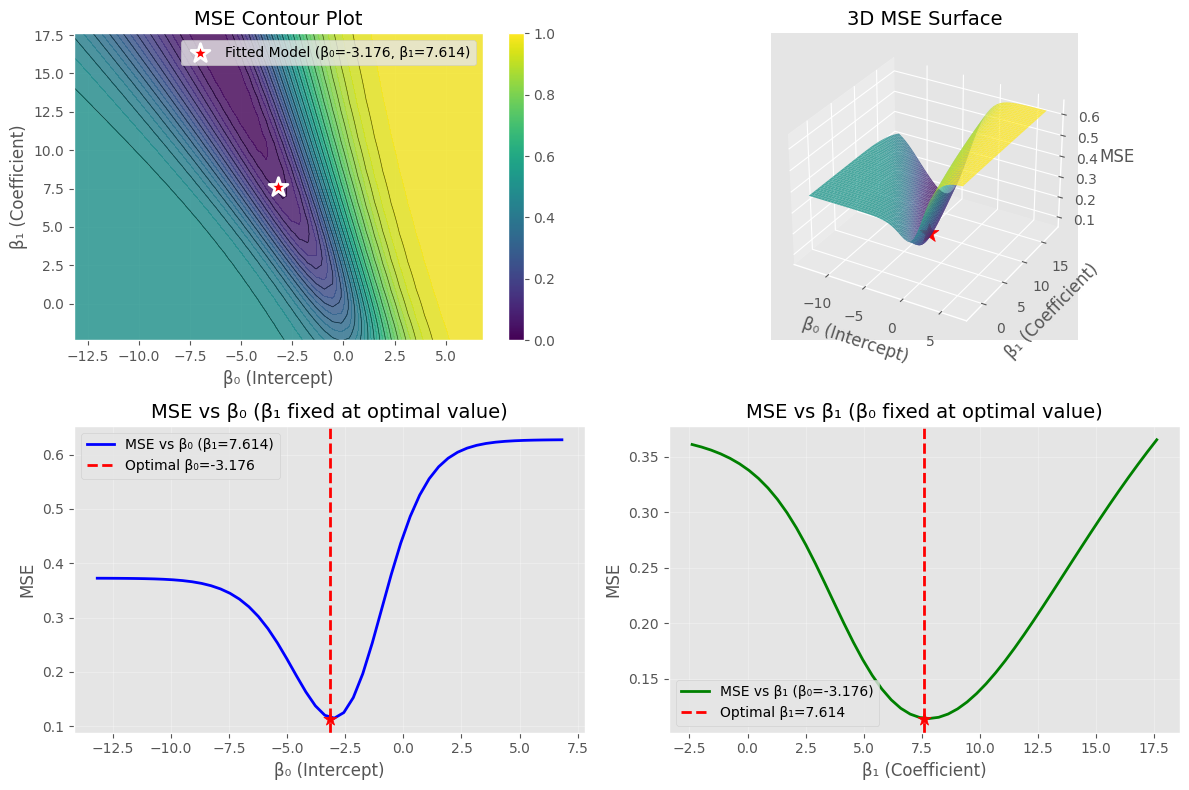

Analysis of MSE with respect to individual parameters:
Optimal β₀: -3.176037
Optimal β₁: 7.613992
MSE at optimal parameters: 0.113908

Minimum MSE in β₀ slice (β₁=7.614): 0.115053
Minimum MSE in β₁ slice (β₀=-3.176): 0.114142


In [266]:
# Create grids for beta0 and beta1 values around the optimal parameters
optimal_beta0 = model.intercept_[0]
optimal_beta1 = model.coef_[0][0]

# Define ranges around the optimal values
beta0_range = 10  # Range around optimal beta0
beta1_range = 10  # Range around optimal beta1
n_points = 50      # Number of points in each dimension

# Create arrays of beta values
beta0_values = np.linspace(optimal_beta0 - beta0_range, optimal_beta0 + beta0_range, n_points)
beta1_values = np.linspace(optimal_beta1 - beta1_range, optimal_beta1 + beta1_range, n_points)

# Create meshgrids
beta0_grid, beta1_grid = np.meshgrid(beta0_values, beta1_values)

# Calculate MSE for each combination of beta0 and beta1
mse_grid = np.zeros_like(beta0_grid)

for i in range(n_points):
    for j in range(n_points):
        # Calculate predicted probabilities using manual logistic function
        linear_combination = beta0_grid[i, j] + beta1_grid[i, j] * np.array(X).flatten()
        y_prob_manual = 1 / (1 + np.exp(-linear_combination))
        
        # Calculate MSE
        mse_grid[i, j] = np.mean((y - y_prob_manual) ** 2)

# Create a comprehensive visualization with 4 subplots
fig = plt.figure(figsize=(12, 8))

# First subplot - 2D contour plot
plt.subplot(2, 2, 1)
contour = plt.contour(beta0_grid, beta1_grid, mse_grid, levels=20, colors='black', alpha=0.6, linewidths=0.5)
contourf = plt.contourf(beta0_grid, beta1_grid, mse_grid, levels=50, cmap='viridis', alpha=0.8)
plt.scatter(optimal_beta0, optimal_beta1, color='red', s=200, marker='*', 
           edgecolor='white', linewidth=2, zorder=5, 
           label=f'Fitted Model (β₀={optimal_beta0:.3f}, β₁={optimal_beta1:.3f})')
plt.xlabel('β₀ (Intercept)', fontsize=12)
plt.ylabel('β₁ (Coefficient)', fontsize=12)
plt.title('MSE Contour Plot', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.colorbar()

# Second subplot - 3D surface plot
ax = fig.add_subplot(2, 2, 2, projection='3d')
surf = ax.plot_surface(beta0_grid, beta1_grid, mse_grid, cmap='viridis', alpha=0.8)
ax.scatter(optimal_beta0, optimal_beta1, 
          np.mean(np.array((y - y_prob_all) ** 2)),  # type: ignore
          color='red', s=200, marker='*', 
          label=f'Fitted Model')
ax.set_xlabel('β₀ (Intercept)', fontsize=12)
ax.set_ylabel('β₁ (Coefficient)', fontsize=12)
ax.set_zlabel('MSE', fontsize=12)
ax.set_title('3D MSE Surface', fontsize=14)

# Third subplot - MSE vs β₀ (fixing β₁ at optimal value)
plt.subplot(2, 2, 3)
# Find the index closest to optimal β₁
optimal_beta1_idx = np.argmin(np.abs(beta1_values - optimal_beta1))
mse_vs_beta0 = mse_grid[optimal_beta1_idx, :]

plt.plot(beta0_values, mse_vs_beta0, 'b-', linewidth=2, label=f'MSE vs β₀ (β₁={optimal_beta1:.3f})')
plt.axvline(optimal_beta0, color='red', linestyle='--', linewidth=2, 
           label=f'Optimal β₀={optimal_beta0:.3f}')
plt.scatter(optimal_beta0, np.mean((y - y_prob_all) ** 2), 
           color='red', s=100, marker='*', zorder=5)
plt.xlabel('β₀ (Intercept)', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('MSE vs β₀ (β₁ fixed at optimal value)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Fourth subplot - MSE vs β₁ (fixing β₀ at optimal value)
plt.subplot(2, 2, 4)
# Find the index closest to optimal β₀
optimal_beta0_idx = np.argmin(np.abs(beta0_values - optimal_beta0))
mse_vs_beta1 = mse_grid[:, optimal_beta0_idx]

plt.plot(beta1_values, mse_vs_beta1, 'g-', linewidth=2, label=f'MSE vs β₁ (β₀={optimal_beta0:.3f})')
plt.axvline(optimal_beta1, color='red', linestyle='--', linewidth=2, 
           label=f'Optimal β₁={optimal_beta1:.3f}')
plt.scatter(optimal_beta1, np.mean((y - y_prob_all) ** 2), 
           color='red', s=100, marker='*', zorder=5)
plt.xlabel('β₁ (Coefficient)', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('MSE vs β₁ (β₀ fixed at optimal value)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Analysis of MSE with respect to individual parameters:")
print(f"Optimal β₀: {optimal_beta0:.6f}")
print(f"Optimal β₁: {optimal_beta1:.6f}")
print(f"MSE at optimal parameters: {np.mean((y - y_prob_all) ** 2):.6f}")
print(f"\nMinimum MSE in β₀ slice (β₁={optimal_beta1:.3f}): {np.min(mse_vs_beta0):.6f}")
print(f"Minimum MSE in β₁ slice (β₀={optimal_beta0:.3f}): {np.min(mse_vs_beta1):.6f}")


## **Log loss**

Despues de haber visto las limitaciones del MSE para problemas de clasificacion, necesitamos una metrica mas apropiada que capture mejor la naturaleza probabilistica de nuestro problema. Aqui es donde entra el **Log Loss** (tambien conocido como **Cross-Entropy Loss** o **Logistic Loss**).

$$
\begin{align*}
    \text{Log Loss} = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{p}_i) + (1 - y_i) \log(1 - \hat{p}_i) \right]
\end{align*}
$$

donde:
- $y_i \in \{0, 1\}$ son las etiquetas verdaderas
- $\hat{p}_i \in [0, 1]$ son las probabilidades predichas por el modelo
- $n$ es el numero de observaciones

### **Fundamentacion: Maxima verosimilitud**

1. **Fundamento teorico solido**: El Log Loss se deriva directamente de los principios de **maxima verosimilitud** para la distribucion Bernoulli. Recordemos que si $Y_i | X_i \sim \text{Bernoulli}(p_i)$, entonces la funcion de verosimilitud es:

$$
\begin{align*}
    L(\theta) = \prod_{i=1}^{n} p_i^{y_i}(1-p_i)^{1-y_i}
\end{align*}
$$

Y la log-verosimilitud (que queremos maximizar) es:

$$
\begin{align*}
    \ell(\theta) = \sum_{i=1}^{n} \left[ y_i \log(p_i) + (1-y_i) \log(1-p_i) \right]
\end{align*}
$$

Minimizar el Log Loss es equivalente a **maximizar la log-verosimilitud**.

2. **Penalizacion apropiada de predicciones incorrectas**: A diferencia del MSE, el Log Loss penaliza mas severamente las predicciones que estan muy seguras pero incorrectas:
   - Si $y_i = 1$ y $\hat{p}_i \to 0$, entonces $\log(\hat{p}_i) \to -\infty$
   - Si $y_i = 0$ y $\hat{p}_i \to 1$, entonces $\log(1-\hat{p}_i) \to -\infty$

3. **Diferenciabilidad y convexidad**: El Log Loss es una funcion convexa y diferenciable, lo que garantiza que los algoritmos de optimizacion encuentren el minimo global, asegurando convergencia estable.

4. **Interpretabilidad probabilistica**: Al estar directamente relacionado con las probabilidades, el Log Loss proporciona una medida mas interpretable del desempeno del modelo en terminos de confianza de las predicciones.

### **Comparacion practica con MSE**

Mientras que el MSE trata todas las desviaciones de manera cuadratica, el Log Loss:
- **Recompensa** predicciones correctas y confiadas (probabilidades cercanas a 0 o 1 cuando corresponde)
- **Penaliza fuertemente** predicciones incorrectas y confiadas
- Es **mas sensible** a diferencias en probabilidades extremas (cerca de 0 o 1)

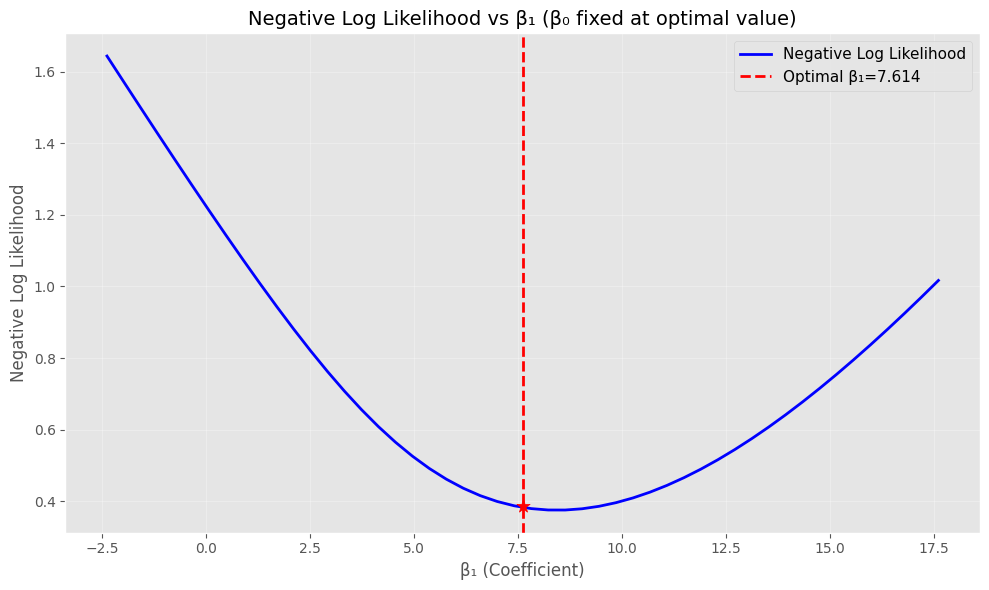

Optimal β₁: 7.613992
Minimum Negative Log Likelihood: 0.375266


In [267]:
from sklearn.metrics import log_loss

# Calculate negative log likelihood for different beta1 values

# Use the same beta1 range as before
beta1_values = np.linspace(optimal_beta1 - beta1_range, optimal_beta1 + beta1_range, n_points)

# Calculate negative log likelihood for each beta1 value (fixing beta0 at optimal)
neg_log_likelihood_beta1 = []

for beta1 in beta1_values:
    # Calculate predicted probabilities using manual logistic function
    linear_combination = optimal_beta0 + beta1 * np.array(X).flatten()
    y_prob_manual = 1 / (1 + np.exp(-linear_combination))
    
    # Calculate negative log likelihood
    # Add small epsilon to avoid log(0)
    epsilon = 1e-15
    y_prob_clipped = np.clip(y_prob_manual, epsilon, 1 - epsilon)
    neg_log_likelihood = -np.mean(y * np.log(y_prob_clipped) + (1 - y) * np.log(1 - y_prob_clipped))
    neg_log_likelihood_beta1.append(neg_log_likelihood)

neg_log_likelihood_beta1 = np.array(neg_log_likelihood_beta1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(beta1_values, neg_log_likelihood_beta1, 'b-', linewidth=2, label='Negative Log Likelihood')
plt.axvline(optimal_beta1, color='red', linestyle='--', linewidth=2, 
           label=f'Optimal β₁={optimal_beta1:.3f}')
plt.scatter(optimal_beta1, neg_log_likelihood_beta1[np.argmin(np.abs(beta1_values - optimal_beta1))], 
           color='red', s=100, marker='*', zorder=5)

plt.xlabel('β₁ (Coefficient)', fontsize=12)
plt.ylabel('Negative Log Likelihood', fontsize=12)
plt.title('Negative Log Likelihood vs β₁ (β₀ fixed at optimal value)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Optimal β₁: {optimal_beta1:.6f}")
print(f"Minimum Negative Log Likelihood: {np.min(neg_log_likelihood_beta1):.6f}")

In [268]:
# Calculate mean square error for logistic regression predictions
y_prob_predictions = model.predict_proba(X)[:, 1]  # Get probabilities for class 1
mse = np.mean((y - y_prob_predictions) ** 2)

print(f"Mean Square Error (MSE): {mse:.6f}")

Mean Square Error (MSE): 0.113908


In [269]:
# Calculate log likelihood loss using scikit-learn
from sklearn.metrics import log_loss

# Calculate log loss on test set
test_log_loss = log_loss(y_test, y_pred)
print(f"Log Loss on Test Set: {test_log_loss:.4f}")

Log Loss on Test Set: 0.3574
